<a href="https://colab.research.google.com/github/TuongHoangTy/Hybrid-Quantum-Classical-Parallel-Fusion-Architecture/blob/main/CNNClassicVsQuantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [2]:
!pip install pennylane torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 60.0 MB/s eta 0:00:00


Mounted at /content/drive
Device: cpu
Đã load results cũ để vẽ biểu đồ (nếu tất cả model đã train xong)


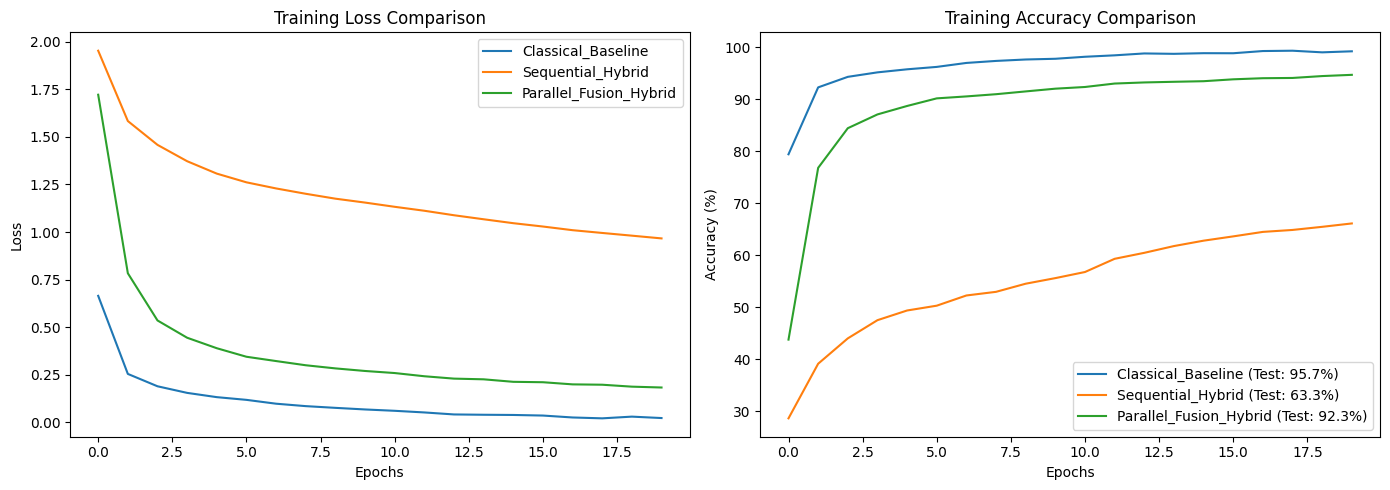

In [3]:
# ==========================================
# QUANTUM HYBRID MNIST - CẢI THIỆN 2026 + CHECKPOINTING
# Cập nhật: Angle Encoding, n_qubits=4, n_layers=2 (Tránh Barren Plateaus)
# ==========================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pickle  # Để lưu results cuối cùng

# ==========================================
# 1. Cấu hình
# ==========================================
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/2-Article'
DATA_PATH = os.path.join(BASE_PATH, 'Data')
MODEL_PATH = os.path.join(BASE_PATH, 'Models')

for path in [DATA_PATH, MODEL_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- ĐIỀU CHỈNH KHỚP BÀI BÁO LÝ THUYẾT ---
n_qubits = 4          # Nén xuống 4 qubit để tạo "bottleneck"
n_layers = 2          # Mạch nông (shallow circuit) để tránh Barren Plateaus
num_epochs = 20
batch_size = 16
print(f"Device: {device}")

# ==========================================
# 2. Mạch lượng tử (Đã sửa thành Angle Encoding)
# ==========================================
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Multi-axis Angle Encoding (Ánh xạ phi tuyến vào mặt cầu Bloch)
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)
        qml.RZ((np.pi / 2) * inputs[i], wires=i)

    # Strongly Entangling Layers (Tạo tương tác Tích Tensor bậc cao)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        # Khởi tạo trọng số cho StronglyEntanglingLayers
        self.weights = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        q_out = []
        for sample in x:
            res = quantum_circuit(sample, self.weights)
            q_out.append(torch.stack(res))
        return torch.stack(q_out).float().to(device)

# ==========================================
# 3. Các mô hình
# ==========================================
class ClassicalCNN(nn.Module):
    def __init__(self):
        super(ClassicalCNN, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Flatten(), nn.Linear(32 * 4 * 4, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.main(x)

class SequentialHybridCNN(nn.Module):
    def __init__(self):
        super(SequentialHybridCNN, self).__init__()
        self.pre = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8, n_qubits), # Nén xuống n_qubits cho Angle Encoding
            nn.Tanh()                 # Ép vào khoảng [-1, 1] cho góc quay
        )
        self.q_layer = QuantumLayer(n_qubits, n_layers)
        self.post = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pre(x)
        x = self.q_layer(x)
        return self.post(x)

class ParallelFusionHybridCNN(nn.Module):
    def __init__(self):
        super(ParallelFusionHybridCNN, self).__init__()
        # 1. Bộ trích xuất dùng chung
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # 2. Nhánh Cổ điển (Xử lý đặc trưng cục bộ)
        self.classical_branch = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(32, 32)
        )

        # 3. Nhánh Lượng tử (Tách rời quy luật tỷ lệ)
        self.q_compress = nn.Linear(8*8, n_qubits) # Nén ảnh 64px -> 4 qubits
        self.q_layer = QuantumLayer(n_qubits, n_layers)

        # 4. Bộ phân loại cuối cùng
        self.classifier = nn.Linear(32 + n_qubits, 10)

    def forward(self, x):
        base = self.feature_extractor(x)
        c_feat = self.classical_branch(base)

        # Tiền xử lý cho nhánh lượng tử: Nén và đưa vào khoảng [-1, 1]
        q_raw = x.flatten(start_dim=1)
        q_input = torch.tanh(self.q_compress(q_raw))
        q_feat = self.q_layer(q_input)

        combined = torch.cat((c_feat, q_feat), dim=1)
        return self.classifier(combined)

# ==========================================
# 4. Huấn luyện với Checkpoint
# ==========================================
def run_experiment(model_class, name, train_loader, test_loader):
    print(f"\n>>> Đang thực hiện: {name}")
    checkpoint_path = os.path.join(MODEL_PATH, f"{name}_checkpoint.pth")
    results_path = os.path.join(MODEL_PATH, "final_results.pkl")

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    start_epoch = 0
    history = {'loss': [], 'acc': []}

    # Load checkpoint nếu tồn tại
    if os.path.exists(checkpoint_path):
        print(f"=> Tìm thấy checkpoint, tiếp tục train từ đó: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        print(f"   Tiếp tục từ epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, correct = 0.0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (out.argmax(1) == labels).sum().item()

        acc = 100 * correct / len(train_loader.dataset)
        avg_loss = train_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['acc'].append(acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Train Acc={acc:.2f}%")

        # Save checkpoint sau mỗi epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }, checkpoint_path)
        print(f"   Đã lưu checkpoint epoch {epoch+1}")

    # Test cuối cùng
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            test_correct += (model(imgs).argmax(1) == labels).sum().item()
    test_acc = 100 * test_correct / len(test_loader.dataset)
    print(f"=> {name} - Test Accuracy: {test_acc:.2f}%")

    return history, test_acc

# ==========================================
# 5. Data
# ==========================================
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(DATA_PATH, train=True, download=True, transform=transform)
test_set = datasets.MNIST(DATA_PATH, train=False, download=True, transform=transform)

train_loader = DataLoader(Subset(train_set, range(8000)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(test_set, range(1000)), batch_size=batch_size)

results = {}

# Load results cũ nếu có (để vẽ biểu đồ mà không cần train lại)
results_path = os.path.join(MODEL_PATH, "final_results.pkl")
if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print("Đã load results cũ để vẽ biểu đồ (nếu tất cả model đã train xong)")

models_to_run = [
    (ClassicalCNN, "Classical_Baseline"),
    (SequentialHybridCNN, "Sequential_Hybrid"),
    (ParallelFusionHybridCNN, "Parallel_Fusion_Hybrid")
]

for m_class, name in models_to_run:
    if name not in results:  # Chỉ train nếu chưa có
        results[name] = run_experiment(m_class, name, train_loader, test_loader)

# Lưu results cuối cùng
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# ==========================================
# 6. Biểu đồ
# ==========================================
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name][0]['loss'], label=name)
plt.title("Training Loss Comparison")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    test_acc = results[name][1]
    plt.plot(results[name][0]['acc'], label=f"{name} (Test: {test_acc:.1f}%)")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.tight_layout()
plt.show()

Mô hình Classical_Baseline: 71,754 tham số.
Mô hình Sequential_Hybrid: 334 tham số.
Mô hình Parallel_Fusion_Hybrid: 6,510 tham số.


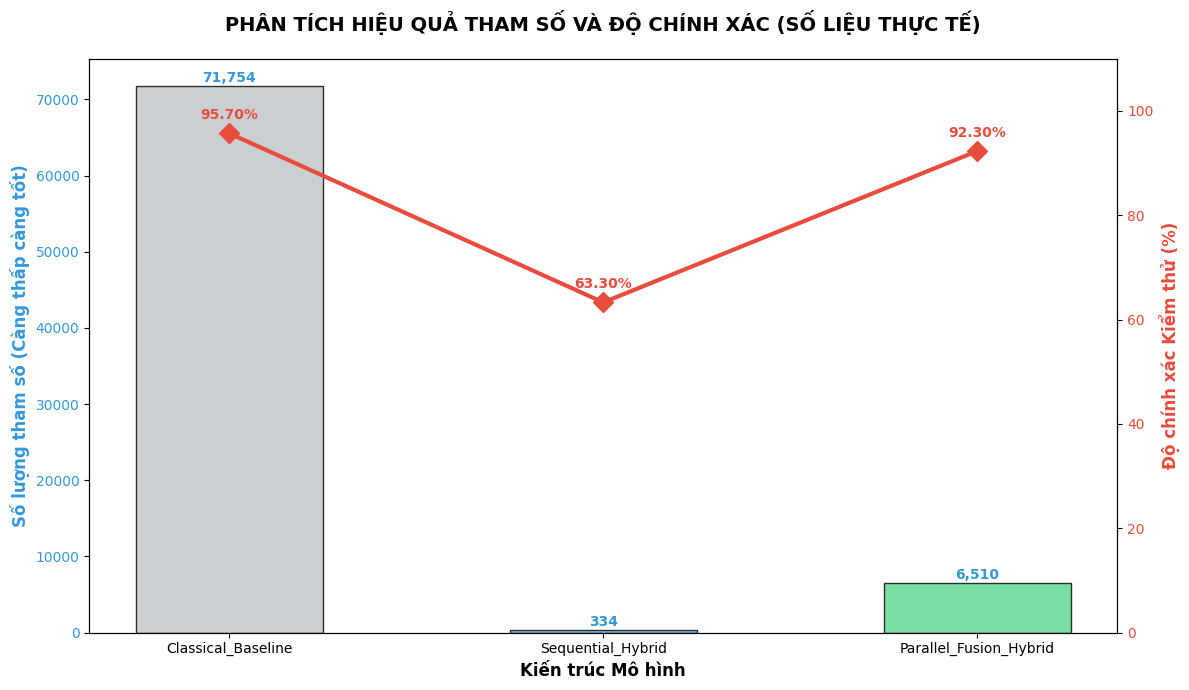

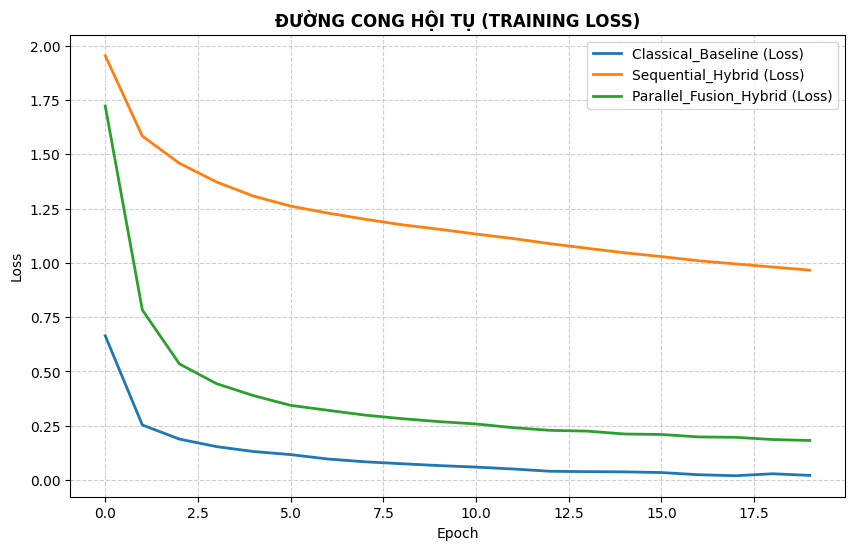

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_model_parameters(model):
    """Hàm tính toán chính xác số lượng tham số học tập của mô hình"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def visualize_scientific_results(results_dict, model_classes):
    """
    Hàm tự động trích xuất số liệu thực từ kết quả huấn luyện và vẽ biểu đồ
    results_dict: Biến 'results' chứa history và test_acc
    model_classes: Danh sách các class mô hình để khởi tạo và đếm tham số
    """
    names = list(results_dict.keys())
    test_accuracies = [results_dict[name][1] for name in names]

    # 1. Tính toán tham số thực tế từ mô hình (Không dùng số cứng)
    param_counts = []
    for m_class, name in models_to_run: # Dựa trên danh sách em đã định nghĩa ở bước trước
        temp_model = m_class()
        count = get_model_parameters(temp_model)
        param_counts.append(count)
        print(f"Mô hình {name}: {count:,} tham số.")

    # 2. Vẽ biểu đồ so sánh Hiệu quả tham số (Parameter Efficiency)
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Vẽ cột tham số (Trục trái)
    color_param = '#3498db'
    ax1.set_xlabel('Kiến trúc Mô hình', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Số lượng tham số (Càng thấp càng tốt)', color=color_param, fontweight='bold', fontsize=12)
    bars = ax1.bar(names, param_counts, color=['#bdc3c7', '#5dade2', '#58d68d'], alpha=0.8, edgecolor='black', width=0.5)
    ax1.tick_params(axis='y', labelcolor=color_param)

    # Ghi số liệu tham số lên đầu cột
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontweight='bold', color=color_param)

    # Vẽ đường Accuracy (Trục phải)
    ax2 = ax1.twinx()
    color_acc = '#e74c3c'
    ax2.set_ylabel('Độ chính xác Kiểm thử (%)', color=color_acc, fontweight='bold', fontsize=12)
    ax2.plot(names, test_accuracies, color=color_acc, marker='D', linewidth=3, markersize=10, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    ax2.set_ylim(0, 110)

    # Ghi phần trăm Acc lên đường biểu diễn
    for i, acc in enumerate(test_accuracies):
        ax2.annotate(f'{acc:.2f}%', (names[i], test_accuracies[i]),
                     textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold', color=color_acc)

    plt.title('PHÂN TÍCH HIỆU QUẢ THAM SỐ VÀ ĐỘ CHÍNH XÁC (SỐ LIỆU THỰC TẾ)', fontsize=14, fontweight='bold', pad=20)
    fig.tight_layout()

    # Lưu file để đưa lên GitHub/Báo cáo
    plt.savefig(os.path.join(BASE_PATH, 'real_parameter_efficiency.png'), dpi=300)
    plt.show()

    # 3. Vẽ biểu đồ Loss Convergence thực tế
    plt.figure(figsize=(10, 6))
    for name in names:
        plt.plot(results_dict[name][0]['loss'], label=f"{name} (Loss)", linewidth=2)
    plt.title('ĐƯỜNG CONG HỘI TỤ (TRAINING LOSS)', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(BASE_PATH, 'real_loss_convergence.png'), dpi=300)
    plt.show()

# Gọi hàm với dữ liệu thực từ biến results của em
visualize_scientific_results(results, models_to_run)


BÁO CÁO THÔNG SỐ VÀ ĐÁNH GIÁ CHUYÊN SÂU
[Classical_Baseline] Tổng số tham số (Parameters): 71,754
[Sequential_Hybrid] Tổng số tham số (Parameters): 334
[Parallel_Fusion_Hybrid] Tổng số tham số (Parameters): 6,510

--- Đánh giá chi tiết mô hình: Parallel_Fusion_Hybrid ---
Classification Report:
              precision    recall  f1-score   support

           0     0.9326    0.9765    0.9540        85
           1     0.9841    0.9841    0.9841       126
           2     0.9123    0.8966    0.9043       116
           3     0.7846    0.9533    0.8608       107
           4     0.9623    0.9273    0.9444       110
           5     0.9865    0.8391    0.9068        87
           6     0.9419    0.9310    0.9364        87
           7     0.9565    0.8889    0.9215        99
           8     0.9390    0.8652    0.9006        89
           9     0.8812    0.9468    0.9128        94

    accuracy                         0.9230      1000
   macro avg     0.9281    0.9209    0.9226      1000


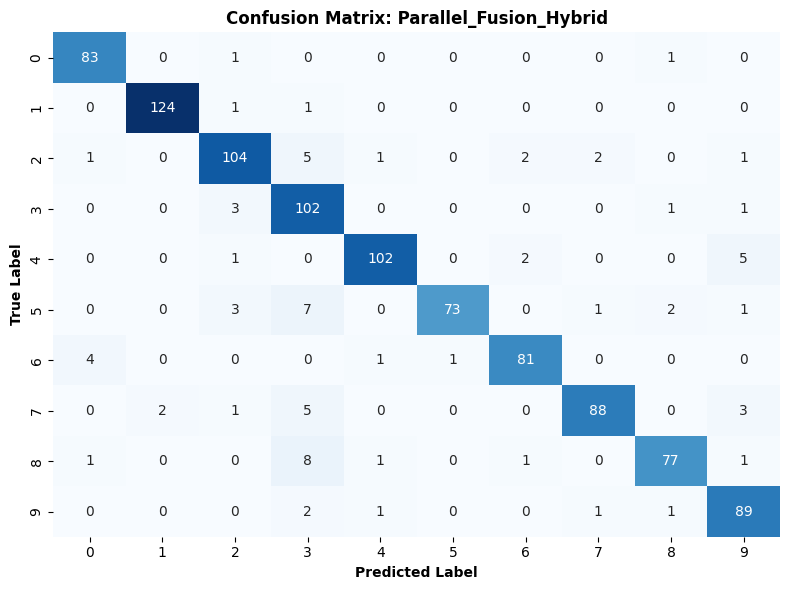

✓ Đã lưu ma trận nhầm lẫn tại: /content/drive/MyDrive/ReseacherAboutQuantumComputer/2-Article/confusion_matrix_Parallel_Fusion_Hybrid.png


In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================================
# 7. CÔNG CỤ ĐÁNH GIÁ CHUYÊN SÂU (EVALUATION TOOLKIT)
# ==========================================

def count_parameters(model, model_name):
    """Đếm số lượng tham số học tập của mô hình"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model_name}] Tổng số tham số (Parameters): {total_params:,}")
    return total_params

def evaluate_and_plot_confusion_matrix(model_class, model_name, test_loader):
    """Tính toán F1-Score và vẽ Confusion Matrix"""
    print(f"\n--- Đánh giá chi tiết mô hình: {model_name} ---")

    # 1. Load trọng số tốt nhất từ Checkpoint
    model = model_class().to(device)
    checkpoint_path = os.path.join(MODEL_PATH, f"{model_name}_checkpoint.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Không tìm thấy checkpoint. Hãy chắc chắn mô hình đã được huấn luyện.")
        return

    model.eval()
    all_preds = []
    all_labels = []

    # 2. Dự đoán trên tập Test
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. In Báo cáo phân loại (Precision, Recall, F1)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # 4. Vẽ Ma trận nhầm lẫn (Confusion Matrix)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])
    plt.title(f'Confusion Matrix: {model_name}', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.tight_layout()
    cm_path = os.path.join(BASE_PATH, f'confusion_matrix_{model_name}.png')
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print(f"✓ Đã lưu ma trận nhầm lẫn tại: {cm_path}")

# --- Thực thi đánh giá ---
print("\n" + "="*50)
print("BÁO CÁO THÔNG SỐ VÀ ĐÁNH GIÁ CHUYÊN SÂU")
print("="*50)

# Đếm tham số
for m_class, name in models_to_run:
    temp_model = m_class()
    count_parameters(temp_model, name)

# Phân tích Confusion Matrix cho mô hình Đề xuất (Parallel Fusion)
evaluate_and_plot_confusion_matrix(ParallelFusionHybridCNN, "Parallel_Fusion_Hybrid", test_loader)